In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.linalg import SparseVector, DenseVector
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

from math import floor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')


#Instantiate the spark session
spark = SparkSession.builder.appName("GBat_model").getOrCreate()

spark.conf.set("spark.sql.shuffle.partitions", 8)

In [2]:
#split each group and return first 80% cycles 
def train_split(grp):
    grp = grp.sort_values(by=['cycle'])
    idx = floor(0.80*grp.shape[0])
    return  grp.iloc[:idx]

#split each group and return rest 20% cycles
def test_split(grp):
    grp = grp.sort_values(by=['cycle'])
    idx = floor(0.80*grp.shape[0])
    return grp.iloc[idx:]

In [3]:
#sMAPE
def sMAPE(y_true, y_pred):
  denominator = (np.abs(y_true) + np.abs(y_pred))
  diff = np.abs(y_true - y_pred) / denominator
  diff[denominator == 0] = 0.0
  sma =200 * np.mean(diff)
  return sma
  
#define function to generate graphs for each cell-protocol combination seperately
def plot_groups(grouped, x, y_true, y_pred):
    
    key_list = list(grouped.groups.keys())
    
    fig, axs = plt.subplots( figsize = (12, 220), dpi= 100, nrows= len(key_list), ncols= 1) 

    targets = zip(key_list, axs.flatten())
        
    for i, (key, ax) in enumerate(targets):
        grp = grouped.get_group(key)
        ax.plot(grp.loc[grp['split'] == 'train', x], grp.loc[grp['split'] == 'train', y_true], label='train: true',
                color='black', marker='.', linestyle='solid' )
        ax.plot(grp.loc[grp['split'] == 'train', x], grp.loc[grp['split'] == 'train', y_pred], label='train: pred',
               color='green', marker='.', linestyle='dashed')
        ax.plot(grp.loc[grp['split'] == 'test', x], grp.loc[grp['split'] == 'test', y_true], label='test: true',
               color='blue', marker='.', linestyle='solid' )
        ax.plot(grp.loc[grp['split'] == 'test', x], grp.loc[grp['split'] == 'test', y_pred], label='test: pred',
               color='magenta', marker='.', linestyle='dashed' )

        ax.set_title("#{}: cell = {} protocol = {}".format(i+1, key_list[i][0], key_list[i][1]) )
        ax.set_xlabel('cycle')
        ax.set_ylabel(y_true)
        ax.legend()
        
    plt.show()

In [4]:
def model_performance_with_plots(trainDF, testDF, labelCol, featuresCol='features', regParam= 0):
  #regParam= (0.8326/(2*8288)),
  RR = LinearRegression(featuresCol=featuresCol, labelCol=labelCol, predictionCol='prediction', regParam=regParam , maxIter=1000, elasticNetParam=0, tol=1e-11, fitIntercept=True, standardization=False, solver='normal', loss='squaredError')
  
  #Train the model on the training using fit() method.
  model = RR.fit(trainDF)

  #Predict on Test Dataset using the evulate method
  test_df_with_pred = model.evaluate(testDF)
  
  #Predict on Train Dataset using the evulate method
  train_df_with_pred = model.evaluate(trainDF)

  #Find out coefficient value
  coefficient = model.coefficients

  #Find out intercept Value
  intercept = model.intercept
  
  #convert to pandas for plotting
  test_df_pd = test_df_with_pred.predictions.toPandas()
  train_df_pd = train_df_with_pred.predictions.toPandas()
  
  #Evaluate the model using metric like Mean Absolute Error(MAE), Root Mean Square Error(RMSE) and R-Square
  evaluation = RegressionEvaluator(labelCol=labelCol, predictionCol="prediction")

  # r2 - coefficient of determination
  r2 = evaluation.evaluate(test_df_with_pred.predictions, {evaluation.metricName: "r2"})

  #RMSE
  rmse = evaluation.evaluate(test_df_with_pred.predictions, {evaluation.metricName: "rmse"})

  #sMape result
  smape = sMAPE(test_df_pd[labelCol], test_df_pd.prediction)
  
  #add column to identify test and train data while plotting before joining the dfs'.
  test_df_pd['split'] = 'test'
  train_df_pd['split'] = 'train'

  #join the dfs' with predicted values for plotting
  final_df_pd = pd.concat([train_df_pd, test_df_pd]).sort_values(by=['cell_no', 'protocol', 'cycle']).reset_index(drop = True)
  
  grouped = final_df_pd.groupby(['cell_no', 'protocol'])
  plot_groups(grouped, 'cycle', labelCol, 'prediction')
  
  return final_df_pd, coefficient, intercept, r2, rmse, smape

In [5]:
#read csv file with aggregated data
cyc_agg_DF = spark.read.csv("/FileStore/tables/agg_clean_DF.csv", inferSchema = True, header = True).cache()

#materialize the DF in memory
cyc_agg_DF.count()

Out[139]: 8288

In [6]:
#convert to pandas to create dummies 
#spark OneHotEncoder creates feature vector, but we need columns with dummies.
#Hence pandas functions is used
cyc_agg_DF_pddf = cyc_agg_DF.toPandas()

#get dummies for each cell_no
cyc_agg_DF_pddf ['cell_dum'] = cyc_agg_DF_pddf ['cell_no']
cyc_agg_DF_pddf = pd.get_dummies(cyc_agg_DF_pddf, prefix=['cell'], columns = ['cell_dum'])

#convert back to spark df
cyc_agg_DF = spark.createDataFrame(cyc_agg_DF_pddf)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:291: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unsupported type in conversion from Arrow: uint8
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)

In [7]:
display(cyc_agg_DF)

cell_no protocol cycle di dur_by_ocv min_ocv max_ocv rng_ocv charge_duration i0x91 i0x2 i0xcd i0x28 i0xb1 i0x83 i0x8c i0x6 i0xa7 i0x2a i0x8a i0x94 i0x73 B_65 B_78 T_5a T_b6 c_const_B_2d c_const_T_c4 c_const_B_81 c_const_B_40 c_const_T_32 c_const_T_bc c_const_B_6b c_const_B_9 c_const_B_3b c_const_B_c9 c_const_B_b2 c_const_B_14 c_const_B_76 c_const_B_29 c_const_T_5 P_const_30 P_const_9f P_const_2c cell_1 cell_3 cell_4 cell_5 cell_6 cell_7 cell_9 cell_10 cell_11 cell_13 cell_14 cell_18 cell_19 cell_20 cell_23 cell_24 cell_26 cell_27 cell_28 cell_29 1 140f77741820c02177597651dfea9fe881c1a73d8e4002a87d0148967cc0f029 4 0.8581709671757066 2.5835794172259505 3329.0 4223.0 894.0 2309.719999 0.4347826086956523 0.59993332222037 0.0 0.8510638297872338 0.2497655517349173 0.6533333333333337 0.5216049382716047 1.0 0.08474576271186438 0.8998330550918195 0.25306122448979607 0.0 0.0 1.0 1.0 0.0 0.75 0.0 0.0 0.0 1.0 0.5 0.09090909090909088 1.0 0.0 1.0 1.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 140f77741820c02177597651dfea9fe881c1a73d8e4002a87d0148967cc0f029 5 0.8378322686997732 2.456929292929293 3439.0 4231.0 792.0 1945.888 0.4347826086956523 0.5999333222203699 0.02451225612806403 0.851063829787234 0.2497655517349173 0.6556521739130435 0.5301932367149756 1.0 0.0847457627118644 0.8824127168469186 0.253061224489796 0.016338779593197735 0.01960784313725489 1.0 1.0 0.0 0.75 0.0 0.0 0.0 1.0 0.5 0.09090909090909088 1.0 0.0 1.0 1.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 140f77741820c02177597651dfea9fe881c1a73d8e4002a87d0148967cc0f029 6 0.6952971199416699 2.940632958801498 3420.0 4221.0 801.0 2355.447 0.4347826086956523 0.5999333222203703 0.004502251125562789 0.8510638297872346 0.24976555173491727 0.7175384615384616 0.7594017094017089 1.0 0.08474576271186426 0.37434185180428825 0.09218210361067482 0.0030010003334444784 0.0036014405762304917 1.0 1.0 0.0 0.75 0.0 0.0 0.0 1.0 0.5 0.09090909090909086 1.0 0.0 1.0 1.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 140f77741820c02177597651dfea9fe881c1a73d8e4002a87d0148967cc0f029 7 0.6931638661496483 2.945014963840399 3419.0 4221.0 802.0 2361.902001 0.4347826086956523 0.5999333222203704 0.00950475237618809 0.8510638297872346 0.24976555173491727 0.7181818181818181 0.7617845117845112 1.0 0.08474576271186426 0.36915060454292414 0.0908472479901049 0.006335445148382798 0.007603041216486587 1.0 1.0 0.0 0.75 0.0 0.0 0.0 1.0 0.5 0.09090909090909086 1.0 0.0 1.0 1.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 140f77741820c02177597651dfea9fe881c1a73d8e4002a87d0148967cc0f029 8 0.7021447505823759 2.903154135338346 3422.0 4220.0 798.0 2316.717 0.4347826086956523 0.5999333222203701 0.019509754877438702 0.8510638297872345 0.2497655517349173 0.713220338983051 0.743408662900188 1.0 0.08474576271186428 0.40918479952463055 0.10114147353856777 0.013004334778259428 0.015606242496998816 1.0 1.0 0.0 0.75 0.0 0.0 0.0 1.0 0.5 0.09090909090909086 1.0 0.0 1.0 1.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 140f77741820c02177597651dfea9fe881c1a73d8e4002a87d0148967cc0f029 9 0.7274330430948969 2.0614544222520106 3476.0 4222.0 746.0 1537.844999 0.4347826086956523 0.5999333222203698 0.03951975987993995 0.8510638297872338 0.2497655517349173 0.7181395348837216 0.7616279069767445 1.0 0.0847457627118643 0.36949178863998156 0.09093497864261986 0.026342114038012673 0.0316126450580232 1.0 1.0 0.0 0.75 1.0 0.0 0.0 1.0 0.5 0.09090909090909086 1.0 0.0 1.0 1.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 140f77741820c02177597651dfea9fe881c1a73d8e4002a87d0148967cc0f029 10 0.6968353462773278 2.9237571964956195 3421.0 4220.0 799.0 2336.082 0.4347826086956523 0.5999333222203702 0.0145072536268134 0.8510638297872346 0.2497655517349173 0.715483870967742 0.7517921146953401 1.0 0.08474576271186426 0.39092035112283824 0.09644502962475292 0.004635953920123908 0.011604641856742702 1

In [8]:
myschema = cyc_agg_DF.schema
    
train_DF = cyc_agg_DF.select("*") \
  .groupBy("cell_no","protocol") \
  .applyInPandas(train_split, schema = myschema) \
  .orderBy("cell_no", "protocol", "cycle") \
  .cache()
  
test_DF = cyc_agg_DF.select("*") \
  .groupBy("cell_no","protocol") \
  .applyInPandas(test_split, schema = myschema) \
  .orderBy("cell_no", "protocol", "cycle") \
  .cache()

print(train_DF.count())
print(test_DF.count())

6608
1680

In [9]:
#columns which are not features
drop_cols = ['cell_no', 'protocol', 'di', 'dur_by_ocv', 'charge_duration', 'cell_1']

vectAssembler = VectorAssembler(inputCols= [col for col in cyc_agg_DF.columns if col not in drop_cols], outputCol="features")

train_DF_with_feat_vect = vectAssembler.transform(train_DF)
test_DF_with_feat_vect = vectAssembler.transform(test_DF)

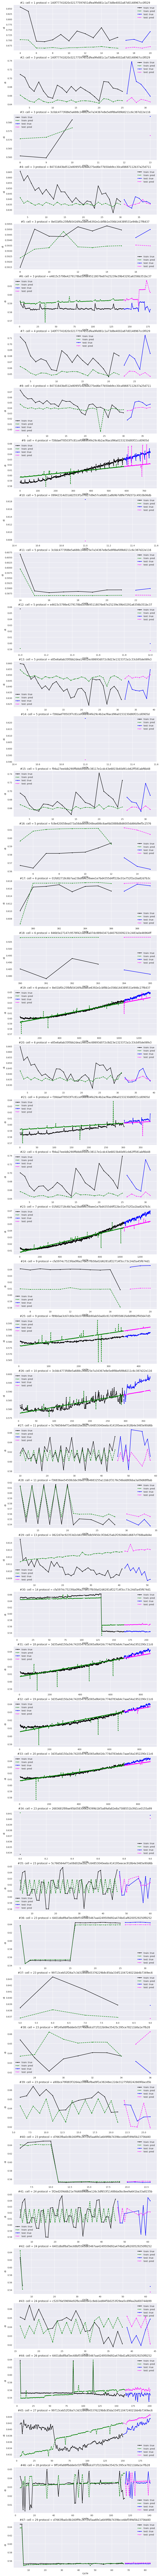

In [10]:
final_df_pd, coefficient, intercept, r2, rmse, smape =  model_performance_with_plots(trainDF = train_DF_with_feat_vect , testDF = test_DF_with_feat_vect , labelCol = 'di', featuresCol='features', regParam= (0.8326/(2*8288)))

In [11]:
print ("The coefficients of the model are : %a" %coefficient)
print ("The Intercept of the model is : %f" %intercept)
print("r2: %.3f" %r2)
print("RMSE: %.3f" %rmse)
print('sMAPE: %f' %smape )

The coefficients of the model are : DenseVector([0.0, -0.0, 0.0, 0.0, 0.0064, 0.013, -0.0067, 0.0411, 0.0024, 0.0072, 0.0468, 0.0143, -0.0414, 0.0916, 0.0186, -0.0061, -0.0067, -0.0005, -0.0061, -0.0561, 0.0041, -0.0011, -0.0015, 0.0, -0.0013, 0.0102, -0.0002, -0.0023, -0.0001, -0.0013, -0.0026, -0.0046, 0.0018, -0.0009, -0.0003, -0.0022, -0.0028, 0.0018, 0.0066, -0.0086, -0.0048, 0.004, -0.0089, -0.005, -0.0243, -0.0044, 0.0009, -0.0048, 0.0107, -0.0047, -0.0058, -0.0038, 0.0052, 0.003, -0.0005, -0.0001, -0.0152, 0.0045])
The Intercept of the model is : 0.478991
r2: 0.860
RMSE: 0.011
sMAPE: 1.291368

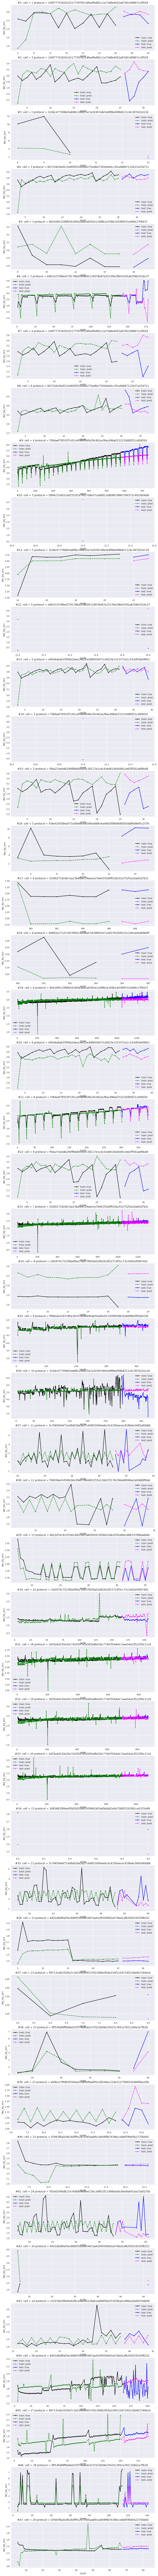

In [12]:
final_df_pd, coefficient, intercept, r2, rmse, smape =  model_performance_with_plots(trainDF = train_DF_with_feat_vect , testDF = test_DF_with_feat_vect, labelCol = 'dur_by_ocv', featuresCol='features', regParam= (0.8326/(2*8288)))

In [13]:
print ("The coefficients of the model are : %a" %coefficient)
print ("The Intercept of the model is : %f" %intercept)
print("r2: %.3f" %r2)
print("RMSE: %.3f" %rmse)
print('sMAPE: %f' %smape)

The coefficients of the model are : DenseVector([-0.0001, 0.002, 0.0008, -0.002, -0.8842, 0.4289, 0.5957, -1.7911, -0.4011, 0.7924, 0.5874, 1.6783, -0.1955, -2.6104, -1.285, 0.1594, 0.6959, 0.488, 0.0388, 0.3165, -0.0636, -0.0391, -0.3458, 0.0, 0.1249, -1.4935, -0.2183, 0.4781, -0.2371, 0.1812, 0.034, 0.0018, -0.042, -0.1359, 0.4434, -0.2203, 1.6816, -0.359, -1.523, -0.6974, -0.7022, -0.6331, -0.8578, 0.538, 1.1696, 0.9615, 0.4949, 1.1641, -0.144, 0.6155, 0.6287, 0.5505, 0.4378, 0.2944, 0.3779, 0.7067, 1.0809, 0.334])
The Intercept of the model is : -6.454804
r2: 0.841
RMSE: 0.494
sMAPE: 6.627449